<span>
<img src="http://ndlib.readthedocs.io/en/latest/_static/ndlogo2.png" width="260px" align="right"/>
</span>
<span>
<b>Author:</b> <a href="http://about.giuliorossetti.net">Giulio Rossetti</a>,  <a href="https://kdd.isti.cnr.it/people/milli-letizia"> Letizia Milli</a>, <a href="https://kdd.isti.cnr.it/people/citraro-salvatore">Salvatore Citraro</a><br/>
<b>Python version:</b>  3.6<br/>
<b>NDlib version:</b>  4.0.1<br/>
</span>

<a id='top'></a>
# *Introduzione a NDlib: Network Diffusion library*

``NDlib`` è una libreria python progettata per fornire supporto all'analisi di fenomeni diffusivi che si verificano su strutture di reti complesse.

In questo tutorial ci focalizzeremo sulla costruzione di modelli a compartimenti (<a href="https://ndlib.readthedocs.io/en/latest/custom/custom.html">documetnazione<a/>)

<a id='install'></a>
## 1. Installare NDlib

Come primo passo, dobbiamo assicurarci che ``NDlib`` sia installato e funzionante.

La libreria è disponibile sia per python  3.x e la sua versione stabile può essere installata usando `` pip``:

In [ ]:
!pip install git+https://github.com/GiulioRossetti/ndlib.git

  Cloning https://github.com/GiulioRossetti/ndlib.git to /tmp/pip-req-build-_3hzf6ai
  Running command git clone -q https://github.com/GiulioRossetti/ndlib.git /tmp/pip-req-build-_3hzf6ai
  Created wheel for ndlib: filename=ndlib-5.1.1-cp37-none-any.whl size=103707 sha256=b5e1e0e0258c2523113f79e3df32580a1870c4d51db37a3c51022a363552e9eb
  Stored in directory: /tmp/pip-ephem-wheel-cache-f_frkhf8/wheels/b3/11/ba/566393d907dc334c2ec583a1e278836807c97ead7da143afdb
Successfully built ndlib


In [ ]:
!pip install matplotlib tqdm

Per verificare che ``ndlib`` sia istallato correttamente provare a fare un import 

In [ ]:
import ndlib

<a id='workflow'></a>
## 2. Simulazione di un'epidemia

Per la simulazione di un fenomeno diffusivo in ``Ndlib`` dobbiamo eseguire i seguenti passaggi:
- Creazione di rete
- Selezione e configurazione del modello di diffusione
- Esecuzione della simulazione
- Visualizzazione dei risultati

Iniziamo da un modello di diffusione semplice, il modello SI.


![picture](https://drive.google.com/uc?export=view&id=1sD6DYaEJLzwD1ZTuKsCocOfVDgqPua2X)

<a id="graph"></a>
### 2.A Creazione o caricamento di un grafo

Come primo passo è necessario creare o caricare una rete che verrà poi utilizzata nello studio del processo diffusivo.

``NDlib`` sfrutta la libreria [``networkx``](https://networkx.github.io).

In questo esempio, viene creato un grafo nel seguente modo:

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Generazione della rete
g = nx.barabasi_albert_graph(500, m=3)

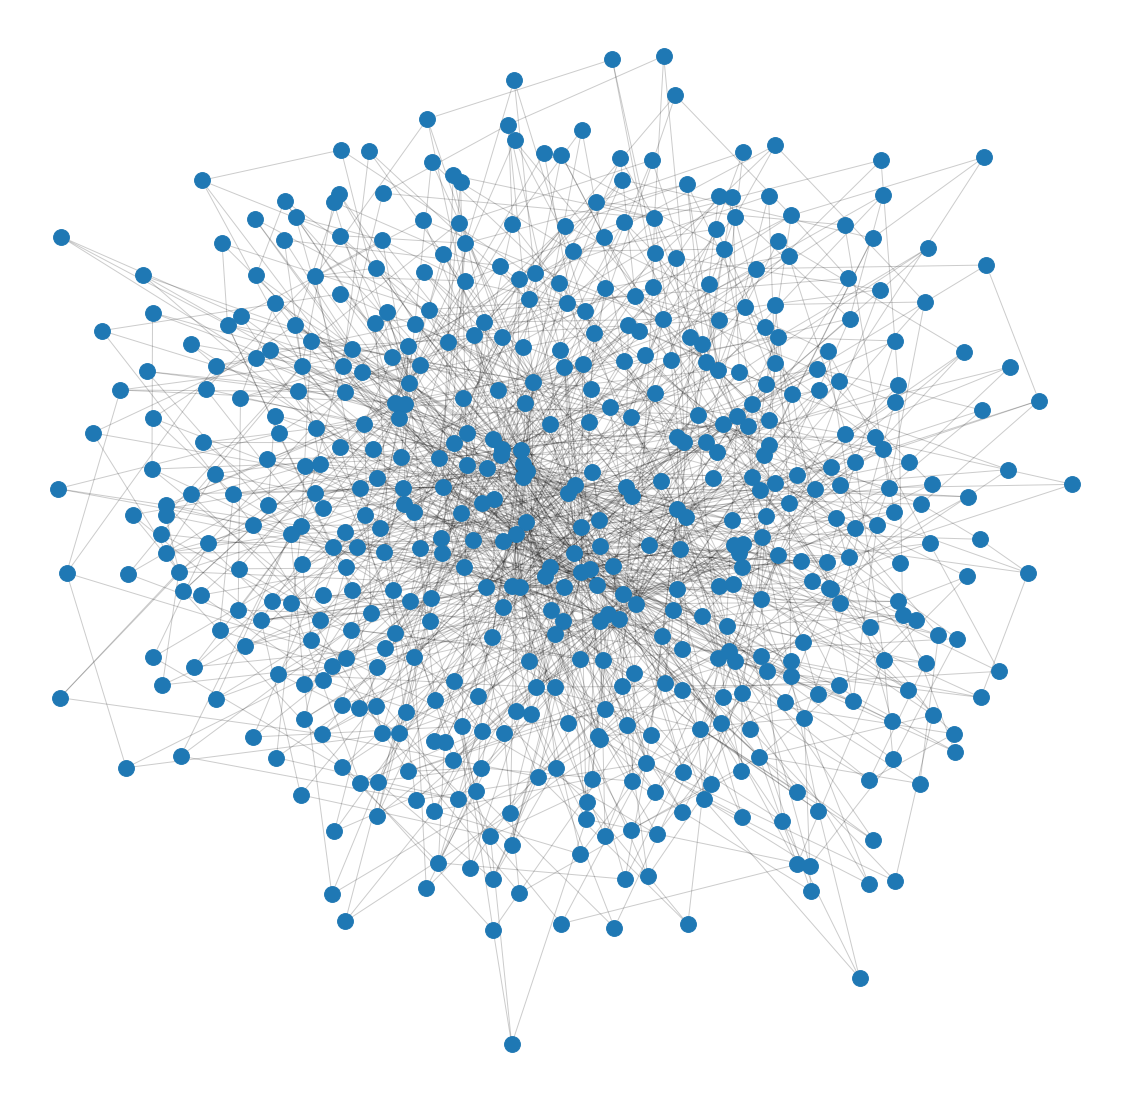

In [ ]:
plt.figure(figsize=(20,20))
pos = nx.spring_layout(g)
nodes = nx.draw_networkx_nodes(g, pos, node_size=250, cmap=plt.cm.plasma)
nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1, base=10))
edges = nx.draw_networkx_edges(g, pos, alpha=0.2)
plt.axis('off')
plt.show()

<a id="model"></a>
### 2.B Inizializzazione del modello e configurazione

Dopo aver definito il grafo, possiamo inizializzare il modello di diffusione da simulare


In [ ]:
import ndlib.models.ModelConfig as mc
import ndlib.models.CompositeModel as gc
import ndlib.models.compartments as cpm
from ndlib.models.compartments.enums.NumericalType import NumericalType


# Inizializzazione del modello
model = gc.CompositeModel(g)

<a id="model_status"></a>
#### 2.B.a Settare gli stati del modello

Il modello *SI* ha due stati:

- S: lo stato delle persone suscettibili
- I: lo stato delle persone infette

Possiamo aggiungere un nuovo stato al nostro modello in questo modo:

In [ ]:
# Stati del modello
model.add_status("Susceptible")
model.add_status("Infected")

<a id="model_rule"></a>
#### 2.B.b Imporre le regole di transizione del modello

Gli individui possono passare da uno stato all'altro. Ad esempio, all'inizio di una nuova influenza tutti gli individui si troveranno nello stato suscettibile. Una volta che una persona entra in contatto con un individuo infetto, potrà diventare a sua volta infetto.
Le regole di transizione impongono come gli individui possono passare da uno stato all'altro e con quale probabilità.

Andiamo quindi ad imporre la regola di cambiamento di sttao per il nostro esempio. Per il modello *SI* esiste una sola regola: dallo stato *suscettibile* (S) si può passare solo allo stato *infetto* (I).

In [ ]:
# Definizione della regola S->I
c1 = cpm.NodeStochastic(0.02, triggering_status="Infected")

model.add_rule("Susceptible", "Infected", c1)

La regola **Suscettibile -> Infetto** appena definita funziona nel seguente modo:
- se un nodo $n$ è *suscettibile* e
- se $n$ ha almeno un vicino *infetto* (`` triggering_status``)
- quindi, con probabilità $0,02$, lo stato di $n$ passerà a *infetto*

<a id="model_inizializzazione"></a>
#### 2.B.c Configurazione dello stato inziale

Andiamo adesso a configurare lo stato iniziale del modello.
Imponiamo nell'esempio che il 10% degli individui nel momento iniziale della simulazione si trovi nello stato Infetto.

In [ ]:
# Configurazione dello stato iniziale
config = mc.Configuration()
config.add_model_parameter('fraction_infected', 0.1)
model.set_initial_status(config)

<a id="simulation"></a>
### 2.C Esecuzione della simulazione

Una volta descritta la rete, il modello e le condizioni iniziali è possibile eseguire la simulazione.

``NDlib`` modella i processi diffusivi come fenomeni a **tempo discreto**: durante ogni iterazione tutti i nodi vengono valutati e viene aggiornato il loro stato in base alle regole definite.

Esistono due metodi che possono essere utilizzati per eseguire iterazioni:
- ``iteration()``
- ``iteration_bunch(n)``

Il primo metodo calcola una sola iterazione, il secondo esegue ``n`` iterazioni. 

In [ ]:
# Esecuzione del modello ->200 iterazioni
iterations = model.iteration_bunch(200)
iterations

[{'iteration': 0,
  'node_count': {0: 450, 1: 50},
  'status': {0: 0,
   1: 0,
   2: 0,
   3: 0,
   4: 0,
   5: 1,
   6: 0,
   7: 0,
   8: 0,
   9: 0,
   10: 0,
   11: 0,
   12: 0,
   13: 0,
   14: 0,
   15: 1,
   16: 0,
   17: 0,
   18: 0,
   19: 0,
   20: 0,
   21: 0,
   22: 0,
   23: 0,
   24: 0,
   25: 0,
   26: 0,
   27: 0,
   28: 0,
   29: 0,
   30: 0,
   31: 0,
   32: 1,
   33: 0,
   34: 1,
   35: 0,
   36: 0,
   37: 0,
   38: 1,
   39: 0,
   40: 0,
   41: 1,
   42: 0,
   43: 1,
   44: 0,
   45: 0,
   46: 0,
   47: 0,
   48: 0,
   49: 0,
   50: 0,
   51: 0,
   52: 0,
   53: 0,
   54: 0,
   55: 0,
   56: 1,
   57: 0,
   58: 0,
   59: 0,
   60: 0,
   61: 0,
   62: 0,
   63: 0,
   64: 0,
   65: 0,
   66: 0,
   67: 0,
   68: 0,
   69: 0,
   70: 1,
   71: 0,
   72: 0,
   73: 0,
   74: 0,
   75: 1,
   76: 0,
   77: 0,
   78: 0,
   79: 0,
   80: 0,
   81: 0,
   82: 1,
   83: 1,
   84: 0,
   85: 1,
   86: 1,
   87: 0,
   88: 0,
   89: 0,
   90: 0,
   91: 0,
   92: 0,
   93: 0,
   94: 0,

Per astrarre è possibile trasformare tutti i dettagli ottenuti con il metodo iteration in **trends** di diffusione usando il metodo ``build_trends(iterations)``:

In [ ]:
trends = model.build_trends(iterations)
trends

[{'trends': {'node_count': {0: [450,
     445,
     444,
     442,
     439,
     431,
     426,
     423,
     416,
     411,
     408,
     402,
     396,
     388,
     387,
     380,
     373,
     365,
     359,
     348,
     345,
     341,
     337,
     329,
     324,
     319,
     316,
     310,
     304,
     303,
     302,
     294,
     290,
     284,
     273,
     269,
     266,
     260,
     255,
     251,
     246,
     239,
     235,
     232,
     228,
     224,
     222,
     214,
     208,
     204,
     200,
     198,
     194,
     189,
     185,
     182,
     179,
     174,
     168,
     163,
     161,
     155,
     151,
     150,
     148,
     145,
     142,
     140,
     139,
     135,
     131,
     129,
     126,
     122,
     120,
     114,
     114,
     112,
     110,
     109,
     107,
     104,
     104,
     102,
     95,
     95,
     95,
     94,
     92,
     92,
     90,
     89,
     88,
     87,
     86,
     83,
     80,
     77,
     75

<a id="top"></a>
###  2.D Visualizzazione dei risultati

Infine, ``NDlib`` permette di vedere il risultato della diffusione ottenuto con il modello di diffusione scelto usando figure standard come il ``DiffusionTrend`` e il ``DiffusionPrevalence``.

Per il nostro esempio, con il ``DiffusionTrend``possiamo vedere ad ogni iterazione la percentuale di Infetti e Suscettibili.

no display found. Using non-interactive Agg backend


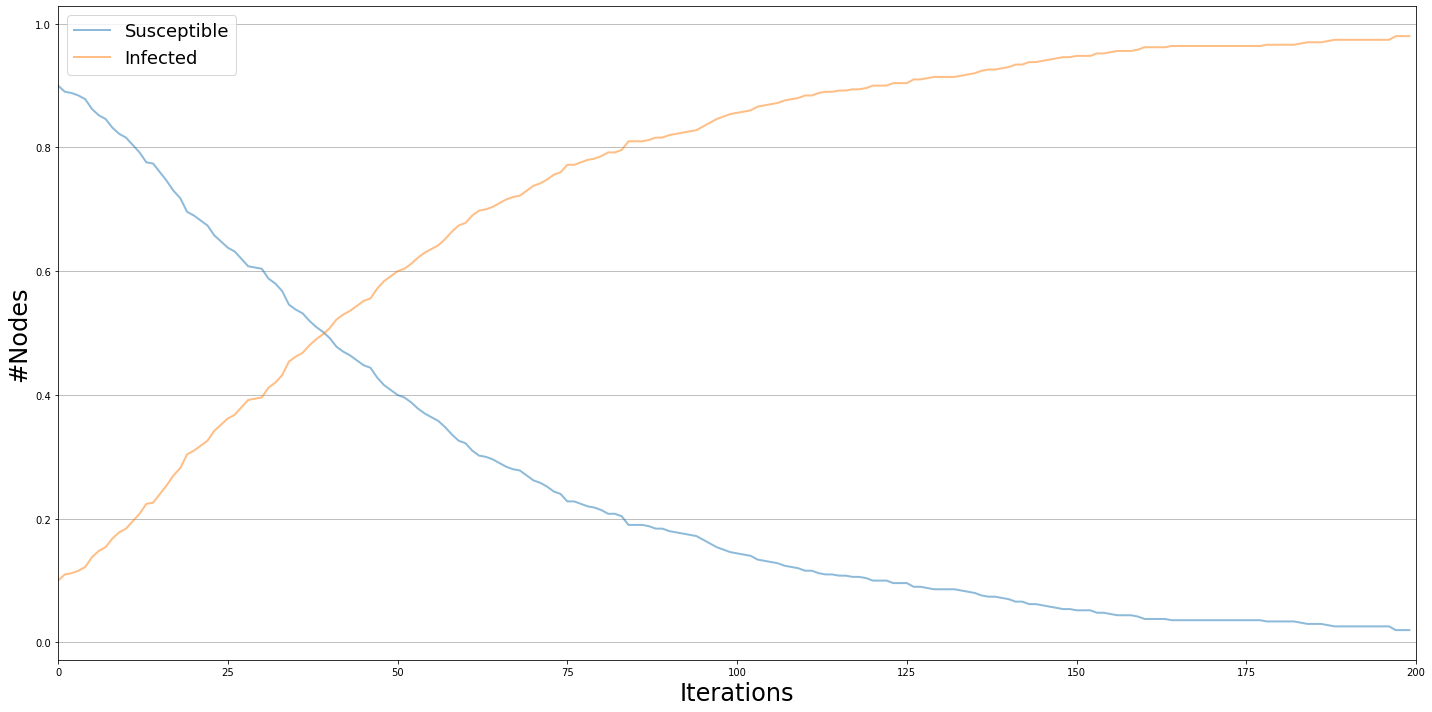

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
viz = DiffusionTrend(model, trends)
viz.plot()

Il plot ``DiffusionPrevalence``, ad ogni iterazione, ci da la variazione del numero di nodi di un certo stato rispetto all'iterazione precedente.

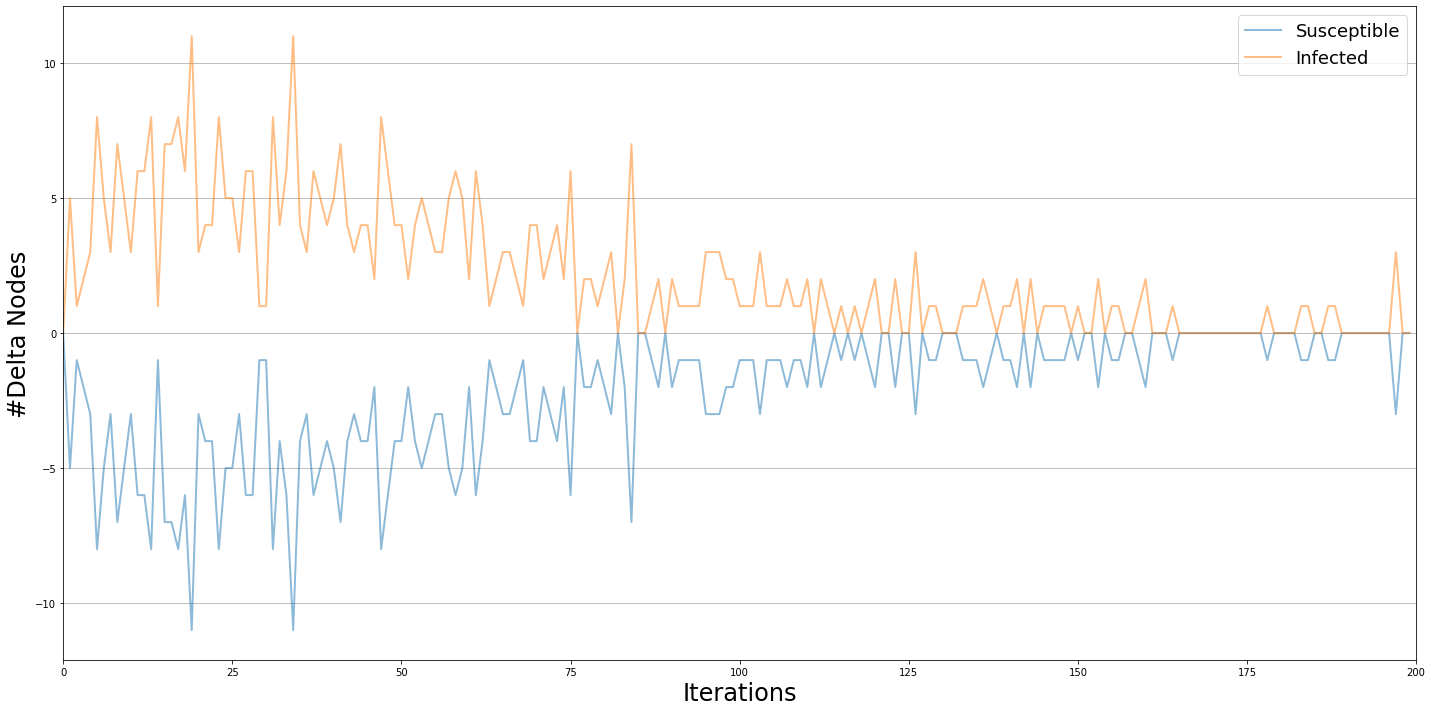

In [ ]:
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence
viz = DiffusionPrevalence(model, trends)
viz.plot()

<a id="Esempi"></a>
## 3. Esercizi

Proviamo adesso a fare delle simulazioni con modelli di diffusione un pò più complessi.



<a id="Esempi1"></a>
### 3.A Modello SIS

![picture](https://drive.google.com/uc?export=view&id=1NI-W6aRt6M53oXgyYPh2S69Lki4Rnd5R)


In questo modello di diffusione, l'individuo dopo essere stato infettato può ritornare nello stato suscettibile. 

Dobbiamo quindi definire una nuova regola **Infetto -> Suscettibile** che funzioni nel seguente modo:
- se un nodo $n$ è *infetto* 
- quindi, con probabilità $0,04$, lo stato di $n$ passerà a *suscettibile*


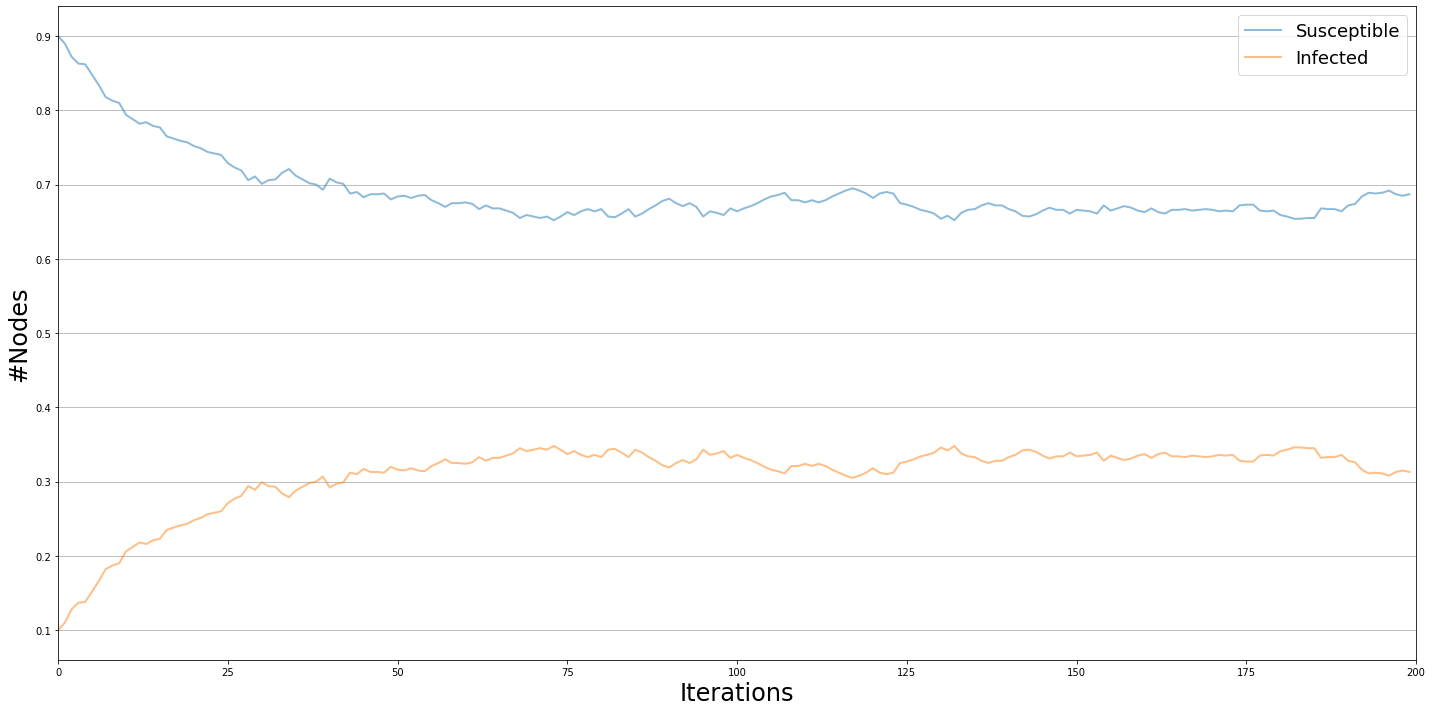

<a id="Esempi2"></a>
### 3.A Modello SIR

![picture](https://drive.google.com/uc?export=view&id=1nf0LyJygJn6WaV6zsjTkO4eMP5B-oKZY)


In questo modello di diffusione, l'individuo dopo essere stato infettato va nello stato *rimosso* e non può più essere infettato. 
Con questo modello abbiamo quindi 3 stati e 2 regole:
- da *suscettibile* a *infetto*
- da *infetto* a *rimosso*

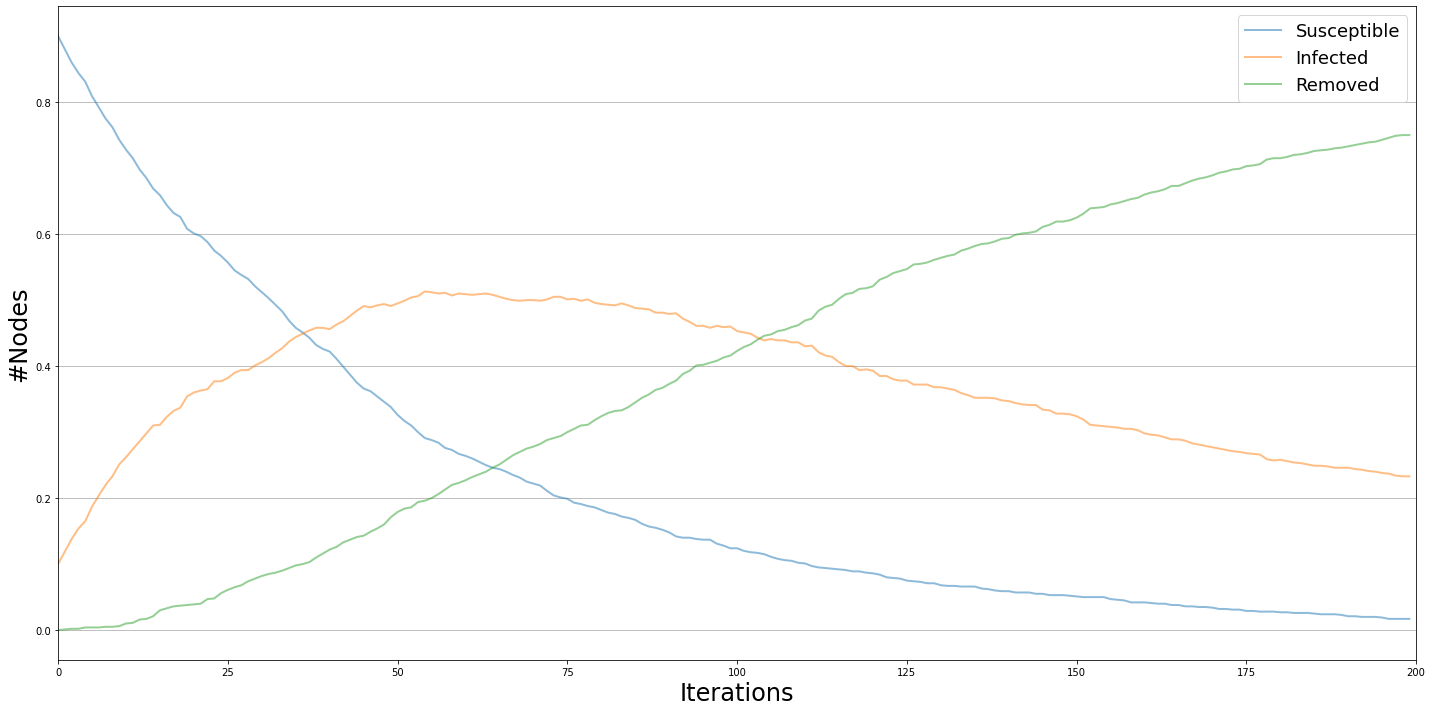

<a id="Esempi3"></a>
### 3.A Modello con incubazione

Supponiamo adesso che dopo un pò di tempo la persona possa nuovamente infettarsi.
Aggiungiamo quindi al nostro modello un periodo di incubazione per passare dallo stato *rimosso* allo stato *suscettibile*.

La regola **rimosso -> suscettibile** definisce il seguente comportamento:
- se un nodo $n$ è *rimosso* viene iniziato un conto alla rovescia chiamato ``incubazione``
- durante ogni iterazione l'``incubazione`` è decrementato
- quando ``incubazione=0``, $n$ diventa *suscettibile*

<a id="Esempi4"></a>
### 3.B Modello a soglia

In questo modello durante un agente ha due alternative comportamentali distinte e che si escludono a vicenda, ad esempio, la decisione di fare o non fare qualcosa, di partecipare o non partecipare a una rivolta.

La decisione individuale dell'agente dipende dalla percentuale dei suoi vicini che hanno fatto la stessa scelta, imponendo così una **soglia**.

Il modello funziona nel modo seguente: 
- ogni nodo ha una propria soglia; 
- durante una generica iterazione si controlla ogni nodo se la percentuale dei suoi vicini infetti è maggiore della sua soglia allora viene infettato anche lui.


**Esempio con soglia fissata**

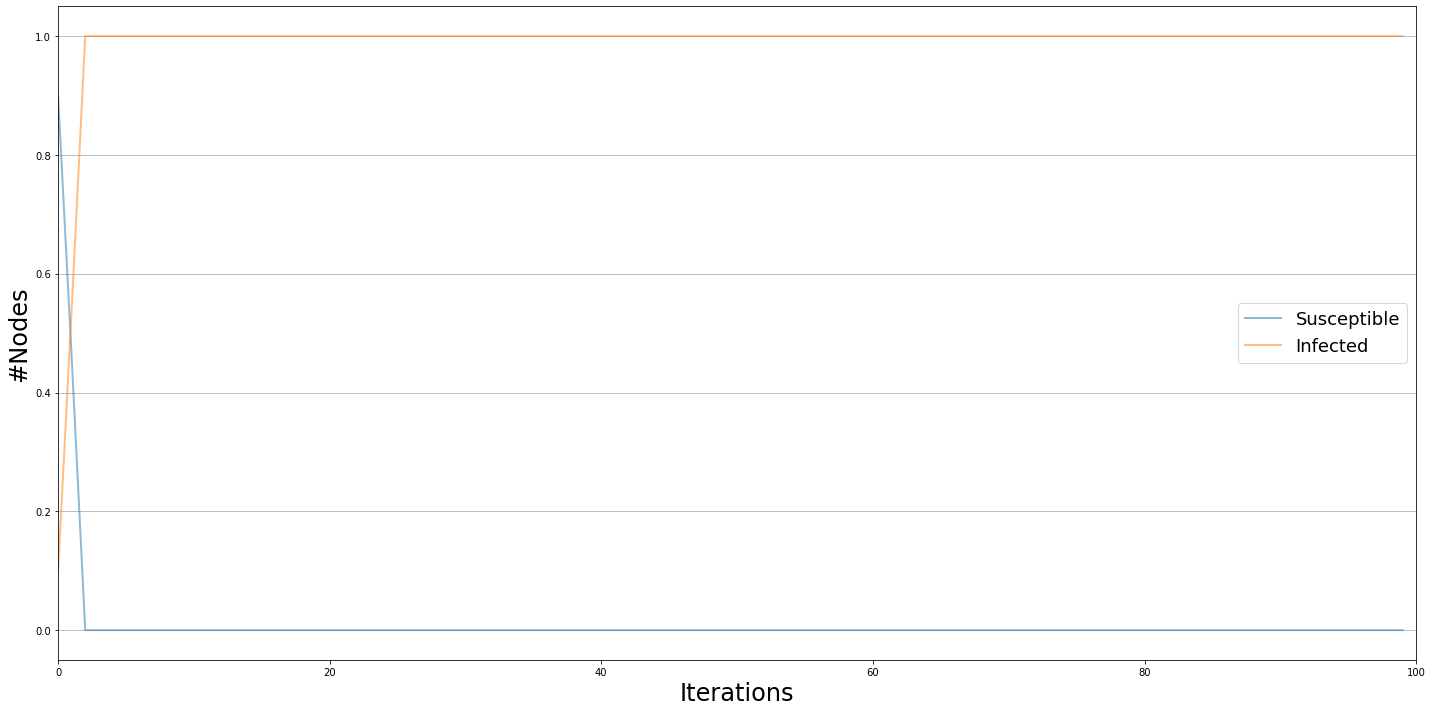

In [ ]:
import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.CompositeModel as gc
import ndlib.models.compartments as cpm
from ndlib.models.compartments.enums.NumericalType import NumericalType
import matplotlib.pyplot as plt
%matplotlib inline 
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend

# Generazione della rete
g = nx.erdos_renyi_graph(1000, 0.1)

# inizializzazione del modello
model = gc.CompositeModel(g)

# stati del modello
model.add_status("Susceptible")
model.add_status("Infected")

# Definizione delle regole
c1 = cpm.NodeThreshold(0.1, triggering_status="Infected")
model.add_rule("Susceptible", "Infected", c1)

# Configurazione dello stato iniziale
config = mc.Configuration()
config.add_model_parameter('fraction_infected', 0.1)

# Esecuzione del modello
model.set_initial_status(config)
iterations = model.iteration_bunch(100)

# visualizzazione del DiffusionTrend
trends = model.build_trends(iterations)
viz = DiffusionTrend(model, trends)
viz.plot()


**Esempio con soglia divesa per ogni nodo**

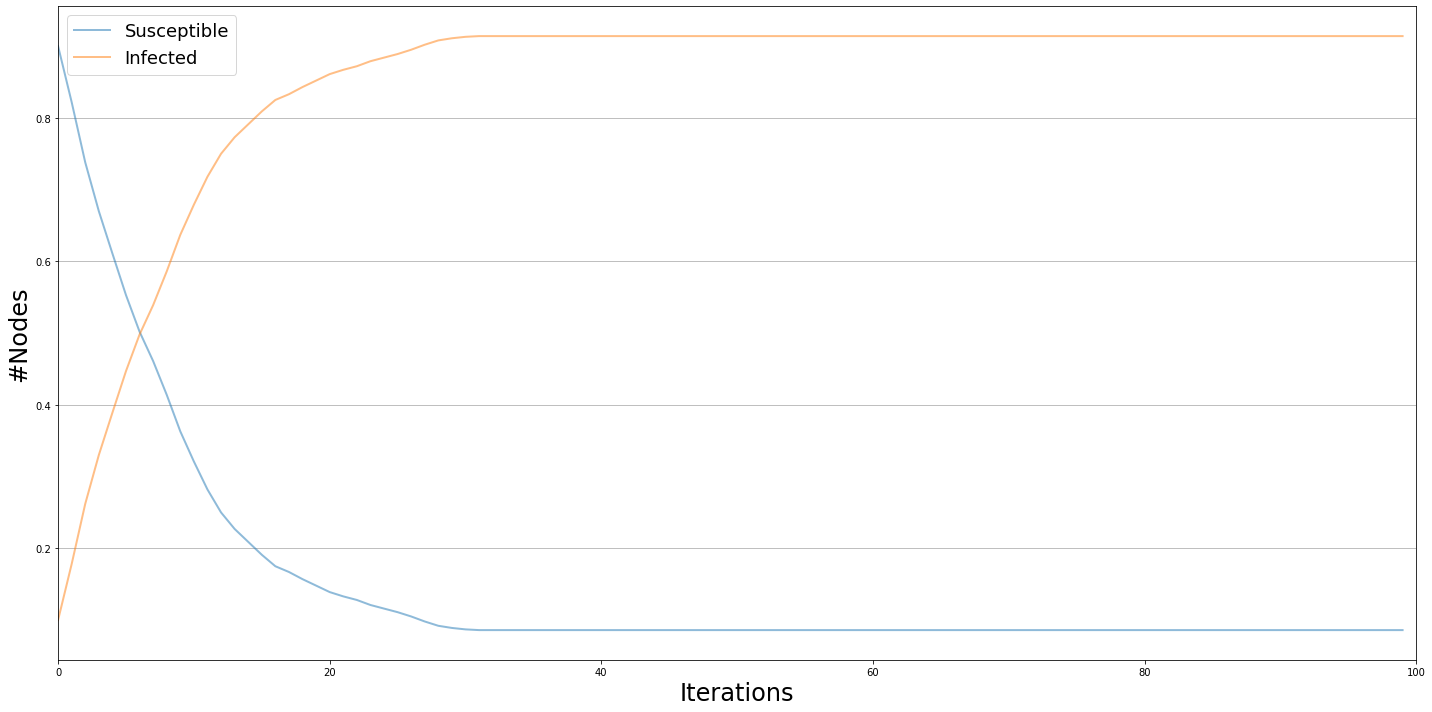

<a id="Opinion dynamic"></a>
## 4. Modellare l'opinione
``NDlib`` permette anche di simulare processi per la dinamica di opinione.
Questi modelli hanno molto in comune con quelli visti per le epidemie.

In generale, gli individui sono modellati come agenti con uno stato e collegati da un social network.
Lo stato è tipicamente rappresentato da variabili, che possono essere discrete (piace/non piace), ma anche continue, rappresentando ad esempio una probabilità di scegliere un'opzione o un'altra. Lo stato degli individui cambia nel tempo, sulla base di una serie di regole di aggiornamento, principalmente attraverso l'interazione con i vicini.

Mentre in molti modelli di diffusione ed epidemie questo cambiamento è irreversibile, nelle dinamiche di opinione lo stato può oscillare liberamente tra i valori possibili, simulando così come le opinioni cambiano nella realtà.*testo in corsivo*


<a id="deffaunt"></a>
### 4.B Modello Deffaunt

Il modello considera una popolazione di individui, dove ogni individuo ha un'opinione continua nell'intervallo $[0,1]$. 
Gli individui sono collegati da un social network e interagiscono a coppie a intervalli di tempo discreti. 
I due individui interagiscono solo se la distanza tra le loro opinioni è minore di una soglia $\epsilon$; questa soglia rappresenta una misura dell'apertura mentale degli individui in una popolazione.

Pertanto, se la distanza tra le opinioni degli individui selezionati è inferiore a $\epsilon$, i due individui adottano la loro opinione media. Altrimenti non succede niente.

Andiamo a vedere il codice per questo esempio.

no display found. Using non-interactive Agg backend


No handles with labels found to put in legend.


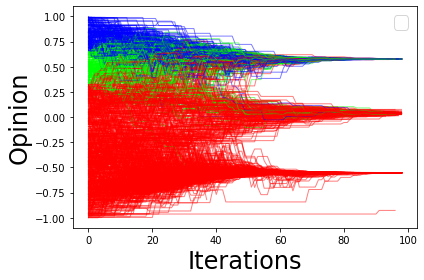

In [ ]:
import networkx as nx
import numpy as np
from ndlib.models.ContinuousModel import ContinuousModel
import ndlib.models.ModelConfig as mc
from ndlib.models.compartments.NodeStochastic import NodeStochastic
from ndlib.viz.mpl.OpinionEvolution import OpinionEvolution
import matplotlib.pyplot as plt
%matplotlib inline 



# Generazione della rete
g = nx.erdos_renyi_graph(n=1000, p=0.1)

# impongo la soglia epsilon = 0.3
constants = {
        'epsilon': 0.3}

# Inizializzazione del modello
model = ContinuousModel(g, constants=constants)

# Stati del modello
model.add_status('opinion')

# Configurazione dello stato iniziale
def initial_status(node, graph, status, constants):
    return np.random.uniform(-1, 1) # ogni individuo ha un'opinione nell'intervallo [-1;1]

initial_status = {
  'opinion': initial_status}

config = mc.Configuration()
model.set_initial_status(initial_status, config)


# funzione di aggiornamento
def update_1(node, graph, status, attributes, constants):
    nb = np.random.choice(graph.neighbors(node))
    if abs(status[node]['opinion'] - status[nb]['opinion']) > constants['epsilon']:
    # se la distanza è maggiore della soglia non cambia l'opinione
        return status[node]['opinion']
    else:
    # la distanza è minore -> aggiorno l'opinione di node, diventa uguale all'opinione media
        return (status[node]['opinion'] + status[nb]['opinion'])/2.0

# Regola di aggiornamento
condition = NodeStochastic(1)
model.add_rule('opinion', update_1, condition)

# Esecuzione del modello
model.set_initial_status(initial_status,config)
iterations = model.iteration_bunch(100)

# visualizzazione
def iteration_for_visualize (iterations):
    list_for_visualize = []
    for step,i in zip(iterations,range(0,100)):
        dic = {}
        for element in step:
            if element != "status":
                dic[element] =step[element]
            else:
                dic['status'] = {}
                for node in step[element]:
                    dic['status'][node] = step[element][node]['opinion']
        list_for_visualize.insert(i,dic)
    return list_for_visualize

list_for_visualize = iteration_for_visualize (iterations)
viz = OpinionEvolution(model, list_for_visualize)
viz.plot()